# STAT 301 Group Project Proposal - Predicting Housing Prices of Residential Homes in Ames, Iowa

#### Authors: Emilio Dorador, Amar Gill, Tanmay Thakral, Yolanda Wu

In [1]:
install.packages('corrplot')
install.packages('regclass')

library(tidyverse)
library(tidyverse)
library(glmnet)
library(broom)
library(leaps)
library(repr)
library(regclass)
library(caret)
library(data.table)
library(mltools)
library(corrplot)
library(car)

options(jupyter.plot_mimetypes = "image/png")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-2

Loading required package: bestglm

Loading required package: VGAM

Loading required package: stats4

Loading required package: splines

Loading required package: rpart

Loading required package: randomForest

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug f

## Introduction

During the sale of a house, it is important for realtors to have accurate and relevant information to help guide the negotiation process (Huang & Rutherford, 2007). As such, it is important for a realtor to have important information regarding the house as well as any statistical inferences that can aid them in the sale since using the internet and other related information based technologies can lead to increased earnings (Benjamin et al., 2002). In this report, we present the results of our analysis aimed at predicting housing prices in Ames, Iowa using linear regression and cross-validation. The data for this analysis was collected in 2010 (Kaggle) and includes various variables related to the characteristics of the homes. Our goal was to identify the critical factors that influence a house's price and to develop a model that can accurately predict these prices. In order to avoid biased estimators and improve model performance, we used the LASSO method for feature selection.

## 1.Exploratory Data Analysis

#### 1.1 - Reading the Dataset

In [2]:
# Read the data into R
housing_data0 <- read_csv("https://raw.githubusercontent.com/yolanda-5/Stat301-Project/main/train.csv")
# housing_data0 represents original raw data loaded in
head(housing_data0)
dim(housing_data0)

Rows: 1460 Columns: 81
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (43): MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConf...
dbl (38): Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, Ye...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000


[1] 1460   81

#### 1.2 - Cleaning and Wrangling the Data into Tidy Format

In [3]:
# Check for NA values in the dataset
total_missing_values <- sum(is.na(housing_data0))
paste("There are", total_missing_values ,"missing values in the dataset")

# Converting categorical variables to data type 'factor'
housing_data <- housing_data0 %>%
  mutate_if(is.character, factor)

[1] "There are 6965 missing values in the dataset"

#### 1.3 - Plotting Relevant Visualizations with Raw Data

First, let's visualize the distribution of the target (response) variable `SalePrice`.

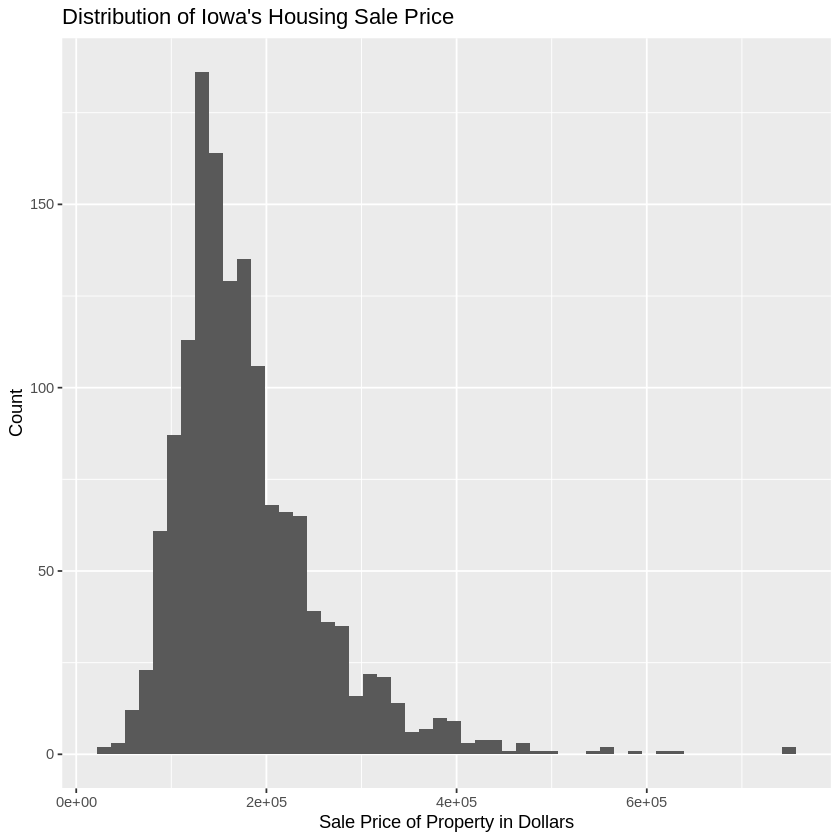

In [4]:
options(jupyter.plot_mime.types = "image/png")

housing_plot <- housing_data %>% ggplot(aes(x = SalePrice)) +
    geom_histogram(bins = 50) +
    xlab("Sale Price of Property in Dollars") +
    ylab("Count") +
    ggtitle("Distribution of Iowa's Housing Sale Price")
housing_plot

*Figure 1.1 Distribution of response variable using histogram*

**Interpretation:** As shown above in Figure 1.1, we observe a unimodal, right skewed distribution for Iona's housing sale price, centered roughly at 150,000 dollars.

Then let's calculate and visualize correlations between variables contained in the dataset to check for multicollinearity and look for any strong relationships between the response and other predictor variables. 

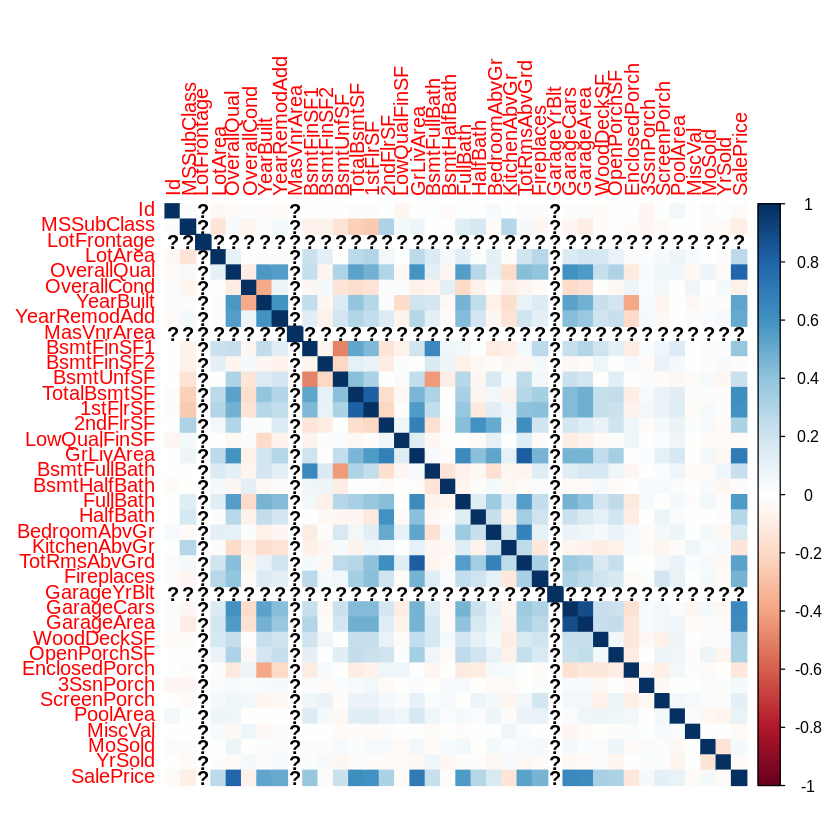

In [5]:
options(jupyter.plot_mime.types = "image/png")

## Calculate the correlation matrix
cor_matrix <- cor(housing_data %>% select_if(is.numeric))
# Visualize the correlations using a heatmap
corrplot(cor_matrix, method = "color")

*Figure 1.2 Heatmap of the correlation matrix for all variables in the raw dataset*

**Interpretation:** The heatmap visualizes the strength of correlation between each pair of variables from the housing dataset, where dark blue indicates strong positive correlation and dark red shows strong negative correlation. Note the diagonal entries are correlations between variables to themselves, hence are all equal to 1.  

#### 1.4 - Calculating Summary Statistics

We use the following code to obtain summary information about the whole housing dataset:

In [6]:
summary(housing_data)

       Id           MSSubClass       MSZoning     LotFrontage    
 Min.   :   1.0   Min.   : 20.0   C (all):  10   Min.   : 21.00  
 1st Qu.: 365.8   1st Qu.: 20.0   FV     :  65   1st Qu.: 59.00  
 Median : 730.5   Median : 50.0   RH     :  16   Median : 69.00  
 Mean   : 730.5   Mean   : 56.9   RL     :1151   Mean   : 70.05  
 3rd Qu.:1095.2   3rd Qu.: 70.0   RM     : 218   3rd Qu.: 80.00  
 Max.   :1460.0   Max.   :190.0                  Max.   :313.00  
                                                 NA's   :259     
    LotArea        Street      Alley      LotShape  LandContour  Utilities   
 Min.   :  1300   Grvl:   6   Grvl:  50   IR1:484   Bnk:  63    AllPub:1459  
 1st Qu.:  7554   Pave:1454   Pave:  41   IR2: 41   HLS:  50    NoSeWa:   1  
 Median :  9478               NA's:1369   IR3: 10   Low:  36                 
 Mean   : 10517                           Reg:925   Lvl:1311                 
 3rd Qu.: 11602                                                              
 Max

*Table 1.1 Summary statistics for the housing dataset*

**Interpretation:** We observe there are many columns in the dataset, including the presence of both numerical and categorical variables.

## 2. Methods

#### *Overview*

To restate the goal of the project, we hope to be able to identify a strong predictive model given the extensive data and number of possible models with varying amounts of predictors. Through this process we also hope to identify a set of predictors that make part of a strong predictive model of housing prices in Ames, Iowa, along with what role these predictors play in our model. With our findings, market agents (i.e. buyers, sellers, realtors, etc.) in the Ames housing market will be able to get insight into predictive pricing for their homes, given a selected number of key characteristics (our predictors).

To achieve our goal, we employed several statistical techniques to analyze the data and build a predictive model. In this section of the report, we will provide a detailed description of our methods with corresponding code and outputs.

#### *Ways to Secure Trustworthiness*

To begin, the data we use comes from real-world sales in Ames, Iowa, and was collected by the American Statistical Association for use in data sciences. This means that each sale is highly authentic. Second, we are investigating a dataset with a significant amount of data (1460 rows). Third, we'll do feature selection, model selection, and best practices like checking for model assumption violations, goodness of model, and so on.

#### *Continuing from Previous Steps*

We made a heatmap of the variables and a histogram of the sale price to see how they relate, but this isn't enough for us to make predictions. As a result, we intend to train a model that captures the relationship between the variables in order to accurately predict the sale price. Going forward, we plan to make use of the model selection methods to optimize our selected model subject to training data. We will be working with a split data set (training and testing data) to be able to build a predictive model with the training set and measure the performance of our predictive model with the testing set. 


#### 2.1 - Variable Selection Using LASSO

One of the first steps in our analysis was to identify the most important variables for predicting housing prices. We used the LASSO method, which is a type of regularization that helps to eliminate unnecessary variables and improve model performance by minimizing the complexity of the model. LASSO works by adding a penalty term to the objective function of the model, which encourages the model to select a smaller number of variables that are more relevant to the outcome.

We recognize that other mothods are available that may improve prediction power, however we want our model to also be relatively interpretable as it would be intended to be used by people that aren't necessarily familiar with model interpretation. LASSO helps us with this by eliminating variables and only selecting those with high prediction power, therefore we believe it fits our use case best by improving interpretability while maintaining strong predictive power.

Let's drop the columns that contain NA values so that lasso works.

In [7]:
housing_data <- housing_data %>%
    select_if(~ !any(is.na(.)))

# Get the dimension of the new dataframe and check for NA values again
dim(housing_data)
total_missing_values <- sum(is.na(housing_data))
paste("There are", total_missing_values ,"missing values in the dataset")

[1] 1460   62

[1] "There are 0 missing values in the dataset"

In [8]:
# Creating the train and test split
set.seed(1234)

housing_data$Id <- 1:nrow(housing_data)
housing_train <- sample_n(housing_data, size = nrow(housing_data) * 0.70, replace = FALSE)
housing_test <- anti_join(housing_data, housing_train, by = "Id")

# Viewing the train and test datasets and gitting the size of the dataframes
head(housing_train)
dim(housing_train)
head(housing_test)
dim(housing_test)

Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,⋯,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
<int>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1308,20,RL,8072,Pave,Reg,Lvl,AllPub,Inside,Gtl,⋯,0,0,0,0,0,5,2009,WD,Normal,138000
1018,120,RL,5814,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,⋯,0,0,0,0,0,8,2009,COD,Abnorml,187500
1125,80,RL,9125,Pave,IR1,Lvl,AllPub,Inside,Gtl,⋯,0,0,0,0,0,7,2007,WD,Normal,163900
1004,90,RL,11500,Pave,IR1,Lvl,AllPub,Corner,Gtl,⋯,0,0,0,0,0,6,2007,WD,Normal,136905
623,20,RL,7064,Pave,Reg,Lvl,AllPub,Inside,Gtl,⋯,0,0,0,0,0,7,2009,WD,Normal,135000
905,20,RL,6173,Pave,IR1,Lvl,AllPub,Inside,Gtl,⋯,0,0,0,0,0,8,2007,WD,Normal,125500


[1] 1021   62

Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,⋯,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
<int>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,⋯,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,⋯,0,0,0,0,0,5,2007,WD,Normal,181500
5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,⋯,0,0,0,0,0,12,2008,WD,Normal,250000
7,20,RL,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,⋯,0,0,0,0,0,8,2007,WD,Normal,307000
8,60,RL,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,⋯,228,0,0,0,350,11,2009,WD,Normal,200000
12,60,RL,11924,Pave,IR1,Lvl,AllPub,Inside,Gtl,⋯,0,0,0,0,0,7,2006,New,Partial,345000


[1] 439  62

Now lets split our dataset into two subsets, one for variable selection and another for out-of-sample testing later on. We will need the former in order to run our LASSO regression and select our variables for the resulting model, and the latter in order to test our model against data it has not seen before. This will be necesary in order to ensure we are not compromising our model with a biased result.

In [9]:
# Split the data into predictor and response variables
x_train <- housing_train %>% select(-SalePrice) %>% data.matrix()
y_train <- housing_train %>% select(SalePrice) %>% data.matrix()

x_test <- housing_test %>% select(-SalePrice) %>% data.matrix()
y_test <- housing_test %>% select(SalePrice) %>% data.matrix()
# Fit the lasso model using 10-fold cross-validation
fit <- cv.glmnet(x_train, y_train, alpha = 1, nfolds = 10)

We now need to create dummy variables for LASSO to interpret properly in our model

In [10]:
# read original data again


housing_data_noNA <- housing_data0 %>%
    select_if(~ !any(is.na(.)))

# Get the dimension of the new dataframe and check for NA values again
dim(housing_data_noNA)
total_missing_values <- sum(is.na(housing_data_noNA))
paste("There are", total_missing_values ,"missing values in the dataset")


#create dummy variable for categorical
housing_data_char <- housing_data_noNA[sapply(housing_data_noNA,is.character)]
housing_data_num <- housing_data_noNA[sapply(housing_data_noNA,is.numeric)]
dummy <- dummyVars(~ ., data=housing_data_char)
housing_char_onehot <- data.frame(predict(dummy, newdata = housing_data_char)) 
housing_char_onehot<- cbind(housing_char_onehot,housing_data_num$Id)
col_names <- names(housing_char_onehot)
housing_char_onehot[,col_names] <- lapply(housing_char_onehot[,col_names] , factor)
colnames(housing_char_onehot)[which(names(housing_char_onehot) == "housing_data_num$Id")] <- "Id"
head(housing_char_onehot)
housing_data_noNA = merge(x=housing_char_onehot,y=housing_data_num,by="Id")

head(housing_data_noNA)

[1] 1460   62

[1] "There are 0 missing values in the dataset"

,MSZoningC..all.,MSZoningFV,MSZoningRH,MSZoningRL,MSZoningRM,StreetGrvl,StreetPave,LotShapeIR1,LotShapeIR2,LotShapeIR3,⋯,SaleTypeNew,SaleTypeOth,SaleTypeWD,SaleConditionAbnorml,SaleConditionAdjLand,SaleConditionAlloca,SaleConditionFamily,SaleConditionNormal,SaleConditionPartial,Id
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0,0,0,1,0,0,1,0,0,0,⋯,0,0,1,0,0,0,0,1,0,1
2,0,0,0,1,0,0,1,0,0,0,⋯,0,0,1,0,0,0,0,1,0,2
3,0,0,0,1,0,0,1,1,0,0,⋯,0,0,1,0,0,0,0,1,0,3
4,0,0,0,1,0,0,1,1,0,0,⋯,0,0,1,1,0,0,0,0,0,4
5,0,0,0,1,0,0,1,1,0,0,⋯,0,0,1,0,0,0,0,1,0,5
6,0,0,0,1,0,0,1,1,0,0,⋯,0,0,1,0,0,0,0,1,0,6


,Id,MSZoningC..all.,MSZoningFV,MSZoningRH,MSZoningRL,MSZoningRM,StreetGrvl,StreetPave,LotShapeIR1,LotShapeIR2,⋯,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,0,1,0,0,1,0,0,⋯,0,61,0,0,0,0,0,2,2008,208500
2,10,0,0,0,1,0,0,1,0,0,⋯,0,4,0,0,0,0,0,1,2008,118000
3,100,0,0,0,1,0,0,1,1,0,⋯,352,0,0,0,0,0,400,1,2010,128950
4,1000,0,0,0,1,0,0,1,0,0,⋯,105,61,0,0,0,0,0,2,2010,206000
5,1001,0,0,0,1,0,0,1,0,0,⋯,0,0,0,0,0,0,0,7,2009,82000
6,1002,0,0,0,1,0,0,1,0,0,⋯,0,20,94,0,0,0,0,1,2007,86000


In [11]:
# Creating the train and test split
set.seed(1234)
housing_data_noNA$Id <- 1:nrow(housing_data_noNA)
housing_train <- sample_n(housing_data_noNA, size = nrow(housing_data_noNA) * 0.70, replace = FALSE)
housing_test <- anti_join(housing_data_noNA, housing_train, by = "Id")

# Viewing the train and test datasets and gitting the size of the dataframes
head(housing_train)
dim(housing_train)
head(housing_test)
dim(housing_test)

,Id,MSZoningC..all.,MSZoningFV,MSZoningRH,MSZoningRL,MSZoningRM,StreetGrvl,StreetPave,LotShapeIR1,LotShapeIR2,⋯,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1308,0,0,0,1,0,0,1,0,0,⋯,0,240,0,0,0,0,0,6,2007,189950
2,1018,0,0,0,1,0,0,1,0,0,⋯,196,0,0,0,0,0,0,1,2008,124900
3,1125,0,0,0,0,1,0,1,0,0,⋯,0,0,129,0,0,0,0,6,2006,89000
4,1004,0,0,0,1,0,0,1,1,0,⋯,0,0,0,0,0,0,0,7,2009,137000
5,623,0,0,0,1,0,0,1,0,0,⋯,0,28,0,0,0,0,0,4,2009,120000
6,905,0,0,0,1,0,0,1,0,0,⋯,64,0,0,0,0,0,0,6,2009,130000


[1] 1021  217

,Id,MSZoningC..all.,MSZoningFV,MSZoningRH,MSZoningRL,MSZoningRM,StreetGrvl,StreetPave,LotShapeIR1,LotShapeIR2,⋯,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,0,1,0,0,1,0,0,⋯,0,61,0,0,0,0,0,2,2008,208500
2,2,0,0,0,1,0,0,1,0,0,⋯,0,4,0,0,0,0,0,1,2008,118000
3,5,0,0,0,1,0,0,1,0,0,⋯,0,0,0,0,0,0,0,7,2009,82000
4,7,0,0,0,1,0,0,1,1,0,⋯,144,104,0,0,0,0,0,7,2008,232000
5,8,0,0,0,1,0,0,1,1,0,⋯,0,0,0,0,0,0,0,6,2007,136905
6,12,0,0,0,0,1,0,1,0,0,⋯,238,0,0,0,0,0,0,8,2009,88000


[1] 439 217

Next, we will use our training data to run a CV simulation and determine the best value to assign our penalization parameter $\lambda$ that will minimize the MSE of the LASSO regression model.


Call:  cv.glmnet(x = Housing_X_train, y = Housing_Y_train, lambda = exp(seq(5,      12, 0.1)), alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index   Measure        SE Nonzero
min   1339    49 1.437e+09 493899555      57
1se   9897    29 1.910e+09 243355248      14

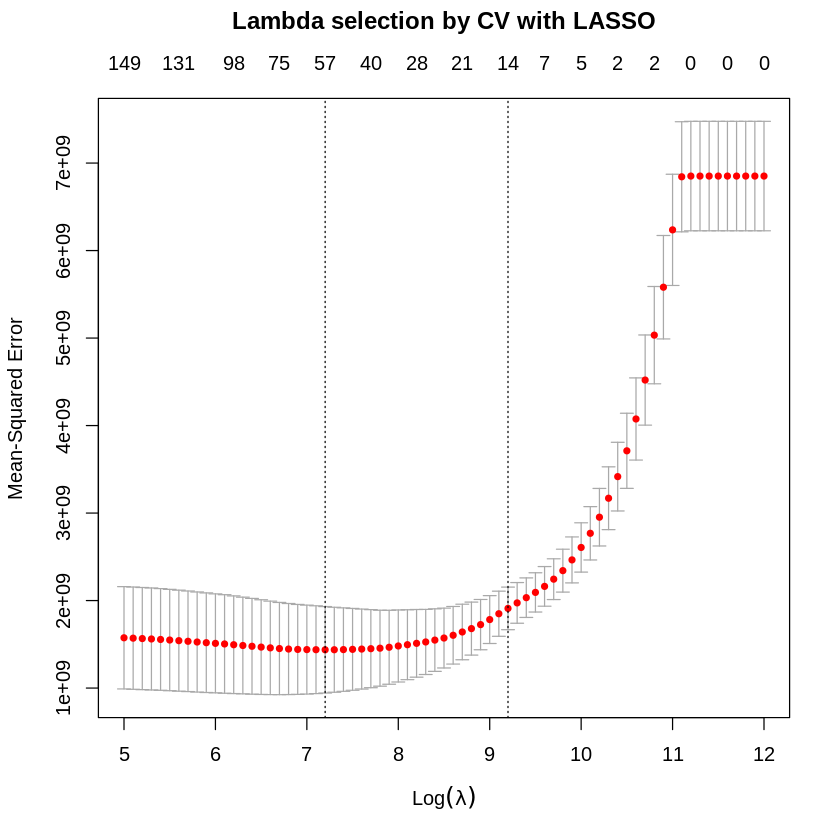

In [12]:
options(jupyter.plot_mime.types = "image/png")

Housing_X_train <- housing_train %>% select(-"SalePrice", "Id")  %>% data.matrix()
Housing_Y_train <- housing_train %>% select("SalePrice")  %>% data.matrix()


Housing_X_test <- housing_test %>% select(-"SalePrice", "Id")  %>% data.matrix()
Housing_Y_test <- housing_test %>% select("SalePrice")  %>% data.matrix()


Housing_cv_lambda_LASSO <- cv.glmnet(
  x = Housing_X_train, y = Housing_Y_train,
  alpha = 1,
  lambda = exp(seq(5, 12, 0.1))
)

Housing_cv_lambda_LASSO

plot(Housing_cv_lambda_LASSO, main = "Lambda selection by CV with LASSO\n\n")


*Table 2.1 Statisitics of lambda.min and lamnda.1se*

*Figure 2.1 Assessing MSE for cross-validations with different values of lambda*

As we can see above, our minimum value of our penalization parameter $\lambda$ is just above exp(7). We get the exact value below:

In [13]:
Housing_lambda_min_MSE_LASSO <- round(Housing_cv_lambda_LASSO$lambda.min, 4)
Housing_lambda_min_MSE_LASSO

[1] 1339.431

We now have all of the necessary values and formatted data to be fed into our optimized LASSO. We fit this model below and report the coefficient estimates on all available variables

In [14]:
Housing_LASSO_min <- glmnet(
  x = Housing_X_train, y = Housing_Y_train,
  alpha = 1,
  lambda = Housing_lambda_min_MSE_LASSO
)

Housing_LASSO_min.coef <- Housing_LASSO_min$beta
Housing_LASSO_min.coef

216 x 1 sparse Matrix of class "dgCMatrix"
                                s0
Id                    .           
MSZoningC..all.      -4.220530e+03
MSZoningFV            .           
MSZoningRH            .           
MSZoningRL            .           
MSZoningRM           -1.222474e+03
StreetGrvl            .           
StreetPave            .           
LotShapeIR1           .           
LotShapeIR2           .           
LotShapeIR3           .           
LotShapeReg           .           
LandContourBnk        .           
LandContourHLS        3.462683e+03
LandContourLow        .           
LandContourLvl        .           
UtilitiesAllPub       .           
UtilitiesNoSeWa       .           
LotConfigCorner       .           
LotConfigCulDSac      8.170775e+03
LotConfigFR2          .           
LotConfigFR3          .           
LotConfigInside       .           
LandSlopeGtl          .           
LandSlopeMod          .           
LandSlopeSev          .           
Neighborhood

*Table 2.2 Optimal LASSO model with selected features and corresponding coefficients*

The above results yield our LASSO selected variables along with their respective coefficients. Using LASSO helps us deal with problems stemming from multicollinearity directly just fitting the model. However, we want to make sure that multicollinearity is not an issue in our model using the LASSO selected models. In order to understand this better, we calculate VIF for our selected variables below:

In [15]:
# check for multicollinearity using vif

lasso_selected_variables <-
    as_tibble(
        as.matrix(Housing_LASSO_min.coef),
        rownames='covariate') %>%
        filter(covariate != '(Intercept)' & abs(s0) > 10e-6) %>% 
        pull(covariate)

variables_vif <- vif(lm(SalePrice ~ . , data = housing_train %>% 
        select(contains(lasso_selected_variables), SalePrice)))

variables_vif

MSZoningC..all.          MSZoningRM      LandContourHLS    LotConfigCulDSac 
           1.180438            2.121893            1.229474            1.133694 
NeighborhoodBrkSide NeighborhoodCrawfor NeighborhoodNoRidge NeighborhoodNridgHt 
           1.348901            1.375464            1.328917            1.744928 
 NeighborhoodNWAmes NeighborhoodOldTown NeighborhoodSomerst NeighborhoodStoneBr 
           1.243645            2.434423            1.402760            1.270385 
     Condition1Norm      Condition1RRAe      Condition2PosN        BldgType1Fam 
           1.221922            1.178329            1.171496            6.230835 
     RoofStyleGable     RoofMatlClyTile     RoofMatlWdShngl  Exterior1stBrkComm 
           1.228378            1.689319            1.150674            1.061652 
 Exterior1stBrkFace  Exterior1stPlywood  Exterior2ndImStucc         ExterQualEx 
           1.204139            1.302694            1.107573            1.868960 
        ExterQualTA     FoundationPConc         HeatingOthW         HeatingQCEx 
           2.596822            2.925867            1.034053            2.316057 
        HeatingQCTA       KitchenQualEx       FunctionalTyp         SaleTypeCOD 
           1.918990            1.878092            1.346816            1.123246 
        SaleTypeCon       SaleTypeConLD       SaleTypeConLI       SaleTypeConLw 
           1.079908            1.095830            1.058190            1.047517 
        SaleTypeCWD         SaleTypeNew          MSSubClass             LotArea 
           1.053316            1.543743            5.671035            1.285406 
        OverallQual         OverallCond           YearBuilt        YearRemodAdd 
           4.280124            1.829635            5.853284            2.560211 
         BsmtFinSF1          BsmtFinSF2         TotalBsmtSF          `1stFlrSF` 
           2.906157            1.238161            4.781082            5.574295 
       LowQualFinSF           GrLivArea        BsmtFullBath        BedroomAbvGr 
           1.159804            5.600356            2.103879            2.048590 
       KitchenAbvGr          Fireplaces          GarageCars          GarageArea 
           1.833023            1.747837            5.732880            5.470961 
         WoodDeckSF         ScreenPorch            PoolArea              MoSold 
           1.272103            1.137761            1.295296            1.085381

*Table 2.3 VIF for each feature*

We can see from the above results that for the most part, we do not need to worry about multicollinearity in our model. There are some variables that report a higher VIF relative to the rest of the selected variables, however, we believe that for the purposes of prediction power, we can ignore these for now as we are not developping a model specifically for inference.

Having selected our variables, we can now begin testing the performance of our model. We are specifically interested in testing the out-of-sample performance of our model as this will help us determine if our model has valuable predicting power. We do this by comparing our estimated SalePrice for the data in our testing subset of the data, and comparing this to the actual observed values stored in this subset. We will do this to determine our model's RMSE for data it has not seen. We will also check our coefficient of determination which will allow us to determine the proportion of the variation in SalePrice that is described by our model. This will help us determine if our model selection was adequate.

In [16]:
Housing_test_pred<- predict(Housing_LASSO_min,
  newx = Housing_X_test)

In [17]:
R_MSE = rmse(
      preds = Housing_test_pred,
      actuals = Housing_Y_test
    )

paste("RMSE: ",  R_MSE)


R_squared <- Housing_LASSO_min$dev.ratio
paste("Coefficient of Determination: ",  R_squared)

[1] "RMSE:  27341.2722425824"

[1] "Coefficient of Determination:  0.910048224428991"

What do these results mean? First lets take a look at our coefficient of determination. Our model yielded a value of 0.91 for our coefficient of determination. Given the context of this project, we believe this is a reasonable result indicating an adequate fit of our model to the data. 

Next, the RMSE value of 27024.61 can be interpreted as the average difference in dollars between the predicted sale prices and the actual sale prices of homes. Intuitively, a lower RMSE value would indicate that the model is able to more accurately predict the sale prices of homes and the differences between the predicted and actual sale prices are smaller on average, and vise versa. As shown in *Figure 1.1*, given the majority of the housing sale prices concentrate around roughly 150000 dollars, we say an error of approximately 27024.61 dollars is acceptable for the purpose of this project. 

### What did we do? Lets Review:

#### Model Fitting

Once we had identified the most important covariates using LASSO, we fitted a linear regression model using these variables. Linear regression is a statistical method that allows us to model the relationship between a dependent variable (in this case, housing prices) and one or more independent variables (the characteristics of the homes). We used cross-validation to determine the most optimal model, which involved dividing the data into several folds and training and evaluating the model on each fold. This helps to reduce the risk of overfitting, which is when the model is too complex and performs poorly on new data. We used the cross-validation scores (CP) as the metric for model assessment in cross-validation.


#### Model Assessment

To evaluate the performance of our model, we conducted a careful model assessment. This included calculating metrics such as R-squared, which measures the amount of variance explained by the model, and root mean squared error (RMSE), which measures the average distance between the predicted values and the true values. These metrics allow us to gauge the accuracy of our model and make any necessary improvements.

## 3. Results

Our analysis yielded several key findings that are relevant to the goal of predicting housing prices in Ames, Iowa. First and foremost, we found that our model had 0.91 for our coefficient of determination, indicating that it explains a significant amount of the variance in the data. This suggests that our model is able to accurately predict housing prices based on the characteristics of the homes. The RMSE value of 27024.61 was also relatively low, further supporting the accuracy of our predictions.

In terms of the specific features that were selected by the LASSO method, we found that 44 variables were included in the final model. These variables were chosen because they had the greatest impact on the outcome, as determined by the LASSO penalty term. We believe we found the right model that factors in interpretability and prediction capacity for the use case example of a realtor.

## 4. Discussion

Overall, our results were in line with what we expected to find. However, there are a few ways in which our model could be improved. One potential approach would be to incorporate additional variables or try a different modeling technique. Additionally, further research could be conducted to explore the implications and impact of our findings in more detail. For example, we could examine how different variables affect housing prices in different parts of Ames, Iowa, or explore the effect of economic factors on the housing market.

In conclusion, our analysis using linear regression, cross-validation, and LASSO was successful in identifying the most optimal model and testing its accuracy on the test data. Our findings have important implications for realtors and other professionals involved in the sale of residential homes in Ames, Iowa, as they can help inform decision-making and ensure that buyers and sellers receive fair value for their properties.


## References

1. Huang, B., & Rutherford, R. (2007). Who you going to call? performance of realtors and non-realtors in a MLS setting. Journal of Real Estate Finance and Economics, 35(1), 77. doi:https://doi.org/10.1007/s11146-007-9029-7

2. Benjamin, J. D., Jud, G. D., Roth, K. A., & Winkler, D. T. (2002). Technology and realtor® income. Journal of Real Estate Finance and Economics, 25(1), 51. Retrieved from https://www.proquest.com/scholarly-journals/technology-realtor®-income/docview/203147731/se-2

3. https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data